In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas
import numpy

import user_test_submission as submission

In [4]:
from clusterer import Clusterer
from sklearn.cluster import DBSCAN
from keras import layers, models
import numpy as np
import math
from metrics import predictor
from sklearn.base import BaseEstimator

Using TensorFlow backend.


# Track Pattern Recognition using Linear Approximation of a Track

## Introduction

Track pattern recognition is an early step of the reconstruction of data coming from a particle detector. It recognizes tracks among the subdetectors hits. Reconstructed track parameters allow to estimate the particle deviation in a magnetic field, and thus reconstruct its charge and momentum. This information is used for the reconstruction of the decay vertex, to identify the mother particle and for further particle identification.

There is wide variety of the track pattern recognition methods. They differ in how they process the hits, what kind of tracks they are able to recognize and which requirements these tracks should satisfy. Therefore, specifics of an experiment and the detector geometry affect the tracking performance and track pattern recognition methods should be adapted to it accordingly.

In this notebook a track pattern recognition for a 2D detector with circular geometry and uniform magnetic field is considered. The detector schema with hits and tracks of an event is shown in the figure below. The challenge is to recognize tracks of an event with the highest efficiecny. It supposed that one hit can belong to only one track. 

<img src="pic/detector.png" /> <br>




## Quick Glossary

We use the following vocabulary in the context of practice session. It may be slightly different from the general high-energy physics context. Some terms are not used in the workbook, but kept here in case they are used in the discussions.

* **event**: a recorded (or simulated) collision in which many particles are present, the basic unit of particle physics data
* **pixel**: the smallest detector unit
* **hit**: a pixel through which a particle has passed and left signal in a given event
* **cluster**: a set of hits, belonging (or predicted to be belonging) to the trajectory of a single particle
* **reconstruct**: same thing as predict, but may also refer to further derived quantities
* **track**: a reconstructed particle, that is, a cluster but also including additional derived information, such as the overall curvature and angle
* **vertex**: the point close to the center of the detector, from which the particles have originated
* **impact parameter**: the shortest distance between a track and the origin
* **(momentum/angle/etc) resolution** : width of the normal distribution of the difference between a predicted quantity and the true value of that quantity

## Objectives

The main objective of the challenge is the optimal matching of the hits in an event. The positions of the hits in the detector are provided as input data, and the user is expected to implement a clustering scheme (trained on data if needed), so that every hit is assigned to a cluster id.

The value of the cluster id itself is not relevant for the task, what is relevant is which hits are clustered together, and whether this clustering corresponds well to the input particles. The score function that describes this is included in the notebook, and details will be mentioned there.

## Application

The user is expected to implement the class `clusterer.py`, which contains the `__init__`, `fit`, and `predict_single_event` functions.

* **`__init__`** is where parameters should be set.
* **`fit`** is the training function (not to be confused with track-fitting), where the algorithm has access to the ground-truth. This function is to be run once on an input array that contains a set of training events. The user is able to implement any event-level or particle-level segmentation of the input array in order to set up the training in any desired way.
* **`predict_single_event`** is the function to reconstruct the hit clusters (tracks), returning an array of predicted (reconstructed) ids associated to each hit in the input array. This function takes only the hits from a single event as input, with the event_id dropped, and the RAMP machinery takes care of running this function on each event.

The **task**  is to implement this class in a way that the predict_single_event function returns a numpy array of assigned cluster ids. At any level of this task, machine-learning techniques can be employed for sub-tasks defined by the user.

## Detector

Image from the Atlas experiment:

<img src="pic/atlas2009.png" /> <br>

The data provided to the user is a list of hit positions from a simple toy detector model that mimics the Atlas detector design (which is generic enough for recent silicon-based tracking detectors). The detector has an onion-like geometry with 9 layers surrounding the origin with polar distances of $R = [39,85,155,213,271,405,562,762,1000]$ cm. These layers have a very small thicknesses compared to the distances, therefore the thickness can be neglected.

Each layer is segmented in azimuth with high granularity. There are ($2\pi$R/pitch)+1 pixels in every layer, where pitch is 0.025 cm for layers 0-4 and 0.05 cm for layers 5-9.

Every "pixel" corresponds to the smallest detector unit defined by `layer` and `iphi` (azimuthal index).

## Simulation

The task uses a toy model for particle generation and simulation, in which a Poisson distribution is sampled to determine the number of particles in each event, with an average of 10 particles per event.

The particles are sampled uniformly in azimuth and momentum with bounds on the momentum. Each particle originates from a vertex that is also randomly sampled from a narrow normal distribution around the origin. The proper dimensions of the momentum and position and determination of these values for the tracks are beyond the scope of the challenge.

The particles generated this way are simulated in a uniform magnetic field. The detector material is considered to cause multiple-scattering, and this is implemented as a random rotation of the particle momentum at every detector position, sampled from a narrow normal distribution that roughly corresponds to the material of the Atlas tracker.

In addition, some hit inefficiency is simulated by a random drop of some hits (with 3% probability), and a particle stopping probability of 1% is applied at each layer to simulate effects of hadronic interactions. Keeping these in mind, the algorithms might be desired to be able to handle cases when the particle doesn't have a hit on every layer.

Since the detector has a very high granularity in azimuth, the cases where two particles pass through a single pixel are neglected (less than 0.2% probability).



## About this notebook

This notebook demonstrate how linear approximation of a track can be used for track pattern recognition. The notebook describes input data, the track pattern recognition method and qualyti metrics, and shows how to use them.

In [5]:
#!sudo pip install sklearn==0.18.1

# Input data

In [6]:
name = "public_train"
data = pandas.read_csv('datasets/'+name+'.csv', index_col=False)
#data = data[data['event_id'].values < 100]

data.head()

,event_id,cluster_id,layer,iphi,x,y
0,3,4,4,53253,53.900430,-265.585662
1,3,1,5,37216,-47.614439,-402.191329
2,3,1,0,7181,-4.253919,-38.767308
3,3,3,2,7937,44.418132,148.499258
4,3,4,0,7657,7.588600,-38.254583


## Exploratory data analysis

### Data Preparation

In [7]:
y = data[['event_id', 'cluster_id']].values
X = data.drop(['cluster_id'], axis=1).values

### Visualize the hits in a single event

In [8]:
event_id = 42
event_indices = (X[:, 0] == event_id)
X_event = X[event_indices, 1:] # event_id column dropped
pixel_x = X_event[:, 2]
pixel_y = X_event[:, 3]
tracks = y[event_indices][: ,1]

#### Hits from all tracks

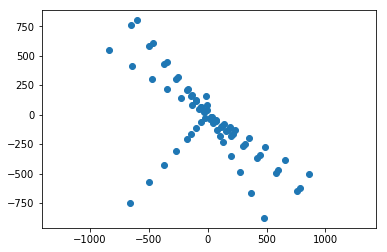

In [9]:
plt.scatter(pixel_x, pixel_y)
plt.axis('equal')
plt.show()

This is what the algorithm will see.

#### Hits from a single track

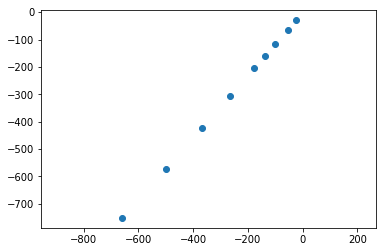

In [10]:
track_id = 2
track_hits = (tracks == track_id)
plt.scatter(pixel_x[track_hits], pixel_y[track_hits])
plt.axis('equal')
plt.show()

So, ideally, our algorithm wants to assign specific ids to all hits in a way that corresponds to the particle. The perfect algorithm will split the event into various tracks:

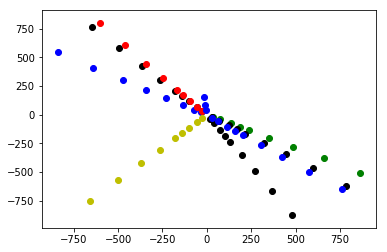

In [11]:
cmap = ['k', 'b', 'y', 'g', 'r', 'k', 'b']
for track_id in np.unique(tracks):
    track_hits = (tracks == track_id)
    plt.scatter(pixel_x[track_hits], pixel_y[track_hits], color=cmap[int(track_id) % 7])
plt.show()

## Train/Test Split

In [12]:
from sklearn.model_selection import train_test_split


event_ids = numpy.unique(data['event_id'].values)

event_ids_train, event_ids_test = train_test_split(event_ids, 
                                                   test_size=1000, 
                                                   random_state=42)

X_train, y_train = X[data['event_id'].isin(event_ids_train)], y[data['event_id'].isin(event_ids_train)]
X_test, y_test = X[data['event_id'].isin(event_ids_test)], y[data['event_id'].isin(event_ids_test)]

# Track Pattern Recognition

## Density-based clustering of a Track

This method is based on the DNSCAN clustering of a track. 

In [13]:
from clusterer import Clusterer
from sklearn.cluster import DBSCAN

ctr = Clusterer(cluster=DBSCAN(eps=0.05, min_samples=1))

ctr.fit(X_train, y_train)

In [14]:
%%time
from metrics import predictor

y_pred_test = predictor(ctr, X_test, y_test)

CPU times: user 1.38 s, sys: 30.6 ms, total: 1.41 s
Wall time: 1.51 s


In [15]:
score = submission.score_function(y_test, y_pred_test)
print("Score: {:1.4f}".format(score))

Score: 0.1414


## RNN-based clustering of a Track

We will use a basic LSTM model architecture used to classify hits for one track. The LSTM and a fully-connected layer with a softmax activation read the pixel arrays and predict which pixels belong to the target track.

<img src="pic/model.png" /> <br>

In [63]:
class det_geo():
    layer_r = np.array([39,85,155,213,271,405,562,762,1000])
    layer_pitch = np.array([0.025, 0.025, 0.025, 0.025, 0.025,
                            0.05, 0.05, 0.05, 0.05])
    num_layers = layer_r.shape[0]
    num_pixels = (2 * np.pi * layer_r / layer_pitch + 1).astype(np.int)
    max_phi = num_pixels # backwards compatibility

def rebin_phi(phi_bin, nbin, layer):
    return (phi_bin * float(nbin) /
            det_geo.num_pixels[layer.astype(np.int)]).astype(np.int)

def rescale_phi(phi_bin, factor):
    return (phi_bin * factor).astype(np.int)

def get_phi(phi_bin, layer, phi_scale=1.):
    return 2*np.pi*phi_bin / math.ceil(det_geo.num_pixels[layer]*phi_scale)

def get_phi_bin(phi, layer, phi_scale=1.):
    # Is this rounding the right way?
    #return int((phi/(2*np.pi)) * det_geo.num_pixels[layer] * phi_scale)
    return int(phi_scale * det_geo.num_pixels[layer] * phi / (2*np.pi))

def get_phi_bin_range(phi_bin, layer, window_size=15, phi_scale=1.):
    phi = get_phi(phi_bin, layer, phi_scale)
    phi_bins = np.array([get_phi_bin(phi, i, phi_scale)
                         for i in range(det_geo.num_layers)])
    return (phi_bins - window_size//2, phi_bins + window_size//2)

def build_model(num_hidden, length, dim,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model




In [66]:
class Clusterer(BaseEstimator):
    def __init__(self, min_cos_value=0.9):
        """
        Track Pattern Recognition based on the connections between
        two nearest hits from two nearest detector layers.

        Parameters
        ----------
        min_cos_value : float
            Minimum cos value between two nearest segments of the track.
        """
        self.min_cos_value = min_cos_value
        self.phi_scale = 1/50.
        self.num_phi_bins = np.ceil(det_geo.num_pixels * self.phi_scale).astype(np.int)
        self.window_size = 501
        self.hidden_dim = 50
        self.model = build_model(self.hidden_dim,
                                 det_geo.layer_r.shape[0],
                                 self.window_size)

        
        
        self.batch_size = 50
        self.num_epoch = 2
        
        # safety check - shouldn't be needed anymore
        #assert (self.num_phi_bins*2 >= self.window_size).all()

    def fit(self, X, y):
        evids, lays, phis = (X[:,0].astype(np.int),
                             X[:,1].astype(np.int),
                             X[:,2].astype(np.int))
        phis = rescale_phi(phis, self.phi_scale)
        #unique_evids = np.unique(evids)
        #num_event = unique_evids.shape[0]
        
        # Count the number of first-layer hits, which will be my seeds
        seed_idx = np.where(lays == 0)[0]
        num_seeds = seed_idx.size
        print( 'Number of seeds: %d' % num_seeds)

        print( 'Preparing training data...')
        # Training input will contain the seed hit followed by the rest of the event
        self.train_input = np.zeros((num_seeds, det_geo.num_layers,
                                     self.window_size))
        # Training targets will be images of the individual signal tracks
        self.train_target = np.zeros_like(self.train_input)
        
        # Loop over training samples to prepare (seeds)
        for i_sample in range(num_seeds):
            i_seed = seed_idx[i_sample]

            # Find all the hits from this event
            evid = y[i_seed, 0]
            ev_idxs = (evids == evid)
            ev_lays, ev_phis = lays[ev_idxs], phis[ev_idxs]
            
            # Transform global phi bins into window pixel number
            pix_min, _ = get_phi_bin_range(phis[i_seed], lays[i_seed], self.window_size)
            ev_pixs = ev_phis - pix_min[ev_lays]
            #print(ev_pixs, ev_phis, pix_min[ev_lays])
            
            # Find the hits which wrap around at phi=0 and are outside the window
            outside_idxs = np.logical_or(ev_pixs < 0, ev_pixs >= self.window_size)
            wrap_pixs_up = ev_pixs - self.num_phi_bins[ev_lays]
            wrap_pixs_dn = ev_pixs + self.num_phi_bins[ev_lays]
            wrap_pixs_up_idxs = np.logical_and(wrap_pixs_up >= 0, outside_idxs)
            wrap_pixs_dn_idxs = np.logical_and(wrap_pixs_dn < self.window_size, outside_idxs)
            ev_pixs[wrap_pixs_up_idxs] = wrap_pixs_up[wrap_pixs_up_idxs]
            ev_pixs[wrap_pixs_dn_idxs] = wrap_pixs_dn[wrap_pixs_dn_idxs]

            # Now select all hits contained in the window
            sample_idxs = np.logical_and(ev_pixs >= 0, ev_pixs < self.window_size)
            sample_lays, sample_pixs = ev_lays[sample_idxs], ev_pixs[sample_idxs]

            # Fill the input first layer with just the seed hit
            self.train_input[i_sample, 0, self.window_size//2] = 1
            #print(i_sample, 0, self.window_size//2)
            # Fill the other layers with all remaining event hits
            #print(i_sample, sample_lays[sample_lays>0], sample_pixs[sample_lays>0])
            self.train_input[i_sample, sample_lays[sample_lays>0], sample_pixs[sample_lays>0]] = 1
            
            # Fill target with all hits from this track
            ev_trkids = y[ev_idxs][:,1]
            ev_sig_idxs = ev_trkids == y[i_seed,1]
            #print ev_pixs[ev_sig_idxs]
            self.train_target[i_sample, ev_lays[ev_sig_idxs], ev_pixs[ev_sig_idxs]] = 1

        print( 'Starting training...'  )    
        self.history = self.model.fit(
            self.train_input, self.train_target,
            batch_size=self.batch_size, nb_epoch=self.num_epoch)

    def predict_single_event(self, X_event):
        
        # We need to now transform the data into the format
        # needed for my algorithm
        lays, phis = (X_event[:,0].astype(np.int),
                      X_event[:,1].astype(np.int))
        # Rebin phi
        phis = rescale_phi(phis, self.phi_scale)
        
        # First, find the seeds
        seed_idx = np.where(lays == 0)[0]
        num_seeds = seed_idx.size
#         print ('Number of seeds: %d' % num_seeds  )  
        
        # Prepare the model inputs
        self.test_input = np.zeros((num_seeds, det_geo.num_layers,
                                    self.window_size))
        # Save the window coordinates for each input as well
        self.window_min = np.zeros((num_seeds, det_geo.num_layers), dtype=int)
        
        # Loop over seeds to prepare
        for i_sample in range(num_seeds):
            i_seed = seed_idx[i_sample]
            
            # Transform global phi bins into window pixel number
            pix_min, _ = get_phi_bin_range(phis[i_seed], lays[i_seed], self.window_size)
            pixs = phis - pix_min[lays]
            self.window_min[i_sample] = pix_min
            
            # Find the hits which wrap around at phi=0 and are outside the window
            outside_idxs = np.logical_or(pixs < 0, pixs >= self.window_size)
            wrap_up = pixs - self.num_phi_bins[lays]
            wrap_dn = pixs + self.num_phi_bins[lays]
            wrap_up_idxs = np.logical_and(wrap_up >= 0, outside_idxs)
            wrap_dn_idxs = np.logical_and(wrap_dn < self.window_size, outside_idxs)
            pixs[wrap_up_idxs] = wrap_up[wrap_up_idxs]
            pixs[wrap_dn_idxs] = wrap_dn[wrap_dn_idxs]

            # Now select all hits contained in the window
            sample_idxs = np.logical_and(pixs >= 0, pixs < self.window_size)
            sample_lays, sample_pixs = lays[sample_idxs], pixs[sample_idxs]

            # Fill the input first layer with just the seed hit
            #print 'Seed pixel:', pixs[i_seed]
            self.test_input[i_sample, 0, int(pixs[i_seed])] = 1
            # Fill the other layers with all remaining event hits
            self.test_input[i_sample, sample_lays[sample_lays>0], sample_pixs[sample_lays>0]] = 1
        
        # Run the model prediction
        self.test_pred = self.model.predict(self.test_input)
        
        # Now we need to loop over all hits and decide which
        # track they belong to
        trkid = np.zeros(X_event.shape[0])
        for i in range(trkid.shape[0]):
            lay, phi = lays[i], phis[i]
            
            scores = np.zeros(num_seeds)
            
            # Loop over each seed
            for j in range(num_seeds):
                pred = self.test_pred[j]
                window_min = self.window_min[j]
                
                # Need to transform into the window coordinates of each seed
                pix = phi - window_min[lay]
                # Correct for wrap-around
                if pix < 0 and pix < self.window_size - self.num_phi_bins[lay]:
                    pix = pix + self.num_phi_bins[lay]
                elif pix >= self.window_size and pix >= self.num_phi_bins[lay]:
                    pix = pix - self.num_phi_bins[lay]
                
                # Check the association score
                if pix >= 0 and pix < self.window_size:
                    scores[j] = pred[lay, pix]
            
            # Get the list of track scores
            #scores = self.test_pred[:, lays[i], phis[i]]
            #print 'scores:', scores
            
            # Select the best score
            best = np.argmax(scores)

            # If the best isn't good enough, it's possible that
            # a track was missing a hit on the first layer.
            # We may be able to improve score by assigning all such
            # tracks to a new class (rather than 'unassigned')
            if scores[best] < 1 / float(self.window_size):
                #print 'Bad best:', scores[best]
                best = scores.shape[0]

            trkid[i] = best
        
        return trkid

In [67]:
ctr = Clusterer()
ctr.fit(X_train, y_train)

Number of seeds: 38565
Preparing training data...
Starting training...
Epoch 1/2
38565/38565 [==============================] - 16s 422us/step - loss: 2.2024 - acc: 0.5019
Epoch 2/2
38565/38565 [==============================] - 16s 404us/step - loss: 0.5678 - acc: 0.8189


In [68]:
ctr.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 9, 501)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 9, 50)             110400    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 9, 501)            25551     
Total params: 135,951
Trainable params: 135,951
Non-trainable params: 0
_________________________________________________________________


In [69]:
y_pred_test = predictor(ctr, X_test[:, 1:], y_test)

In [73]:
score = submission.score_function(y_test, y_pred_test)
print("Score: {:1.4f}".format(score))

Score: 0.9326


In [ ]:
#TODO: implement some visualisations

# Tasks:
1. Define a new function ```build_deep_model``` and create a new model: add a few dense layers before and after the LSTM layer. Play a bit with the shapes of the layers.
2. Define a new function ```build_bidirectional_model``` and create a new model: use a bidirectional LSTM layers instead of a single LSTM layer. Use ```keras.layers.Bidirectional``` layer wrapper. Play a bit with the shapes of the layers.


# Solutions:

In [ ]:
def build_deep_model(num_hidden, length, dim,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.TimeDistributed(layers.Dense(num_hidden, activation='softmax'))(inputs)
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(hidden)
    hidden = layers.TimeDistributed(layers.Dense(num_hidden, activation='softmax'))(hidden)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [ ]:
def build_bidirectional_model(num_hidden, length, dim,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.Bidirectional(layers.LSTM(output_dim=num_hidden, return_sequences=True))(inputs)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model